In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
#For converting between geolocal and numerical ages
from pyrolite.util.time import Timescale

import scipy

import sys
sys.path.insert(1, '../pygplates_rev28_python37_win64')
import pygplates

import ptt

import glob
import os

In [36]:
df=pd.read_excel("Petlab_Jun2019_v8_Horomaka_edit.xlsx",engine='openpyxl')
#print(df.columns.values)
df.head()

,Sample_ID,Collection,Coll_No,Plot_unit,Feature_Type,Feature_Name,Top_Depth,Bottom_Depth,Field_Number,Collection_Date,...,age_model_assumed_Ma,Sr87_86i_calc,Nd143_144i_calc,eNdi_calc,Hf176_177i_calc,eHfi_calc,Pb206_204i_calc,Pb207_204i_calc,Pb208_204i_calc,Petlab notes
0,32257,GNS P (P),40894,Whakaari,Surface,NaN,NaN,NaN,NaN,1981-01-01 00:00:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,125909,GNS P (P),79818,Arc,Surface,NaN,NaN,NaN,LS1,40220,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,169088,other,RVAN-17-13.1,Arc,Dredge,Nesmeyanov-N17-13,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,106981,other,BFH-MP112,Horomaka,Surface,NaN,NaN,NaN,NaN,33604,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,107013,other,BFH-MP279,Horomaka,Surface,NaN,NaN,NaN,NaN,33604,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


For every point in the petlab dataset (volcanic rock samples) we need to determine the:
 - age of its formation.
 - reconstructed position of its formation at that age.
 - values of various time-dependent geophysical grids at each reconstructed formation position.

In [37]:
#Start by setting/determingin a numerical age for every sample
#Set a function for numerical timescale conversion
ts=Timescale()

# print(ts.text2age(df['Age_Max'][622]))
# print(df['Age_Max'][622])
# print(ts.text2age(df['Age_Min'][622]))
# print(df['Age_Min'][622])

In [38]:
#Few ways to do this. Maybe an average of all geological max/mins?
#Max geological age might be beginning of eruptions? So set that for now
#and use if their is no analytical age associated with the sample.
df['Age_Num']=df.apply(lambda row: ts.text2age(row['Age_Max'])[0], axis=1)

#Function to clean up a numerical age
def ager(x):
    #First, if it has an analytical age, use that
    if ~pd.isnull(x['age_sample_result_Ma']): return x['age_sample_result_Ma']
    #Otherwise use the numerical age set before from the geological age
    elif ~pd.isnull(x['Age_Num']): return x['Age_Num']
    #Otherwise set to nan
    else: return np.nan
    
df['Age']= df.apply(ager, axis=1)

(array([761.,  68., 117.,  12.,   5.,   1.,   3.,   2.,   1.,   2.]),
 array([  0. ,  38.1,  76.2, 114.3, 152.4, 190.5, 228.6, 266.7, 304.8,
        342.9, 381. ]),
 <BarContainer object of 10 artists>)

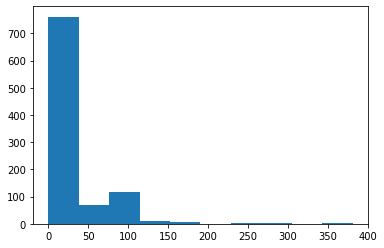

In [94]:
#The grids only go to 250Ma, so anything older than that will have some missing info.
plt.hist(df['Age'])

In [40]:
#Drop unnecessary columns for clarity. Or just keep em, why not.
# df.drop(columns=['Collection','Coll_No', 'Feature_Type',
#  'Feature_Name', 'Top_Depth', 'Bottom_Depth', 'Field_Number',
#  'Collection_Date', 'Date_Rounding', 'Collectors', 'Country_Name',
#  'NZMG_Sheet', 'NZMG_East', 'NZMG_North', 'Method',
#  'Accuracy', 'Site_Description', 'In_Situ', 'Rock_Description', 'Colour',
#  'Sample_Types', 'Lab_Sample_ID(s)', 'Material(s)', 'Part_Analysed',
#  'Analysis_ID(s)', 'Investigator(s)', 'Analysis_Method(s)',
#  'Geochron_Method(s)', 'Laboratory(s)', 'Lab_Number(s)', 'Analysis_Date(s)',
#  'Analysis_Date_Rounding(s)', 'Analysis_Publication(s)',
#  'Analysis_Bib_Ref(s)','Analysis_Comment(s)','Petlab notes'],inplace=True)

dict_keys(['Cambrian', 'Carboniferous', 'Cretaceous', 'Eocene', 'Jurassic', 'Miocene', 'Oligocene', 'Paleocene', 'Permian', 'Pliocene', 'Precambrian', 'Quaternary', 'Triassic'])
Cambrian (541.0, 485.4)


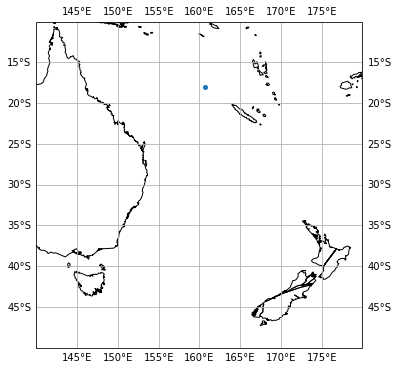

Carboniferous (358.9, 298.9)


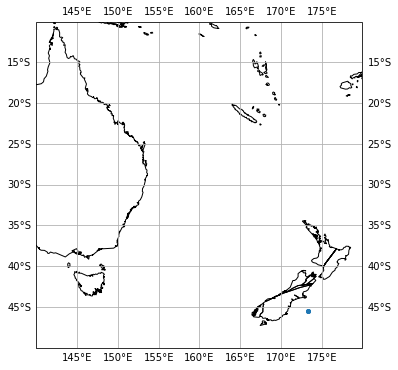

Cretaceous (145.0, 66.0)


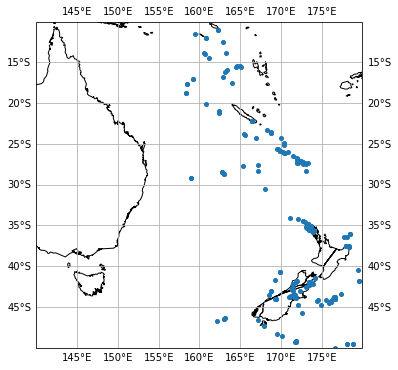

Eocene (56.0, 33.9)


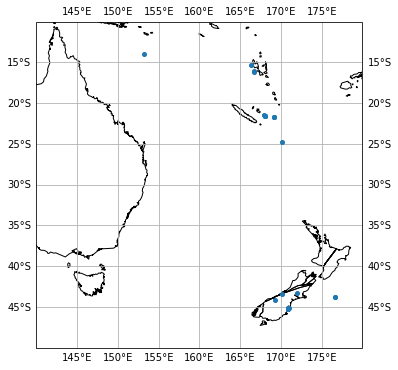

Jurassic (201.3, 145.0)


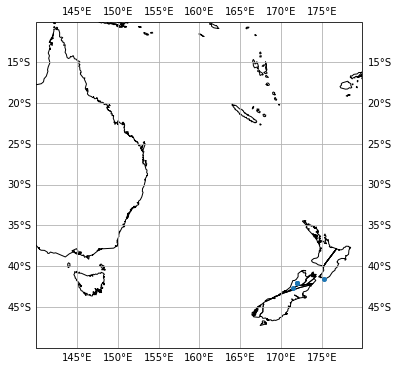

Miocene (23.03, 5.332999999999999)


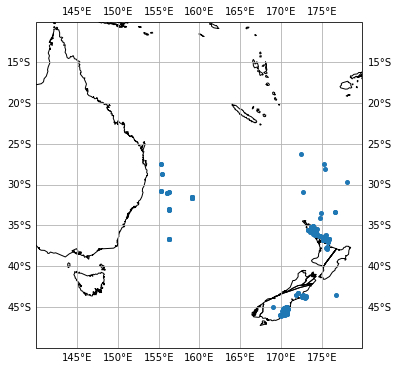

Oligocene (33.9, 23.03)


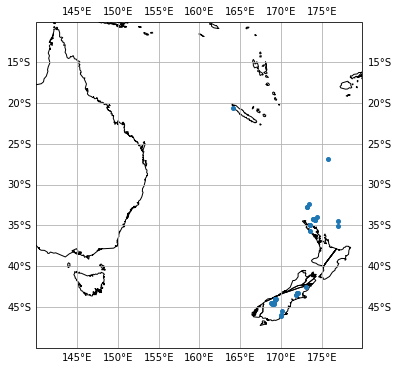

Paleocene (66.0, 56.0)


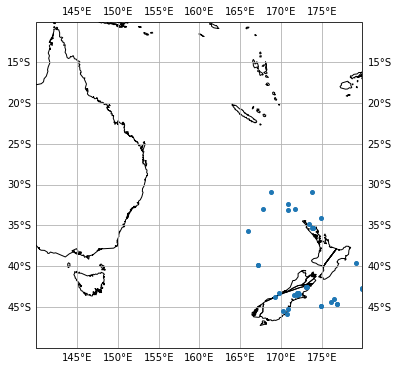

Permian (298.9, 251.90200000000002)


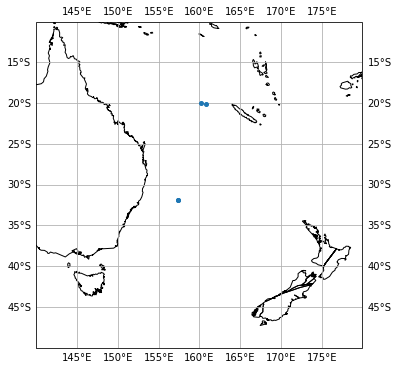

Pliocene (5.332999999999999, 2.58)


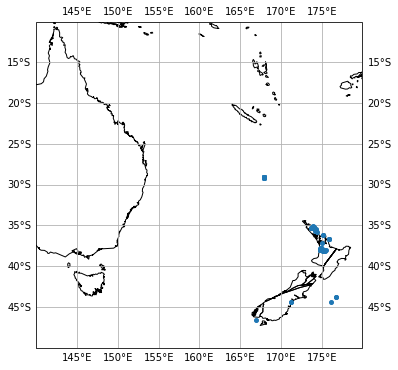

Precambrian (4600.0, 541.0)


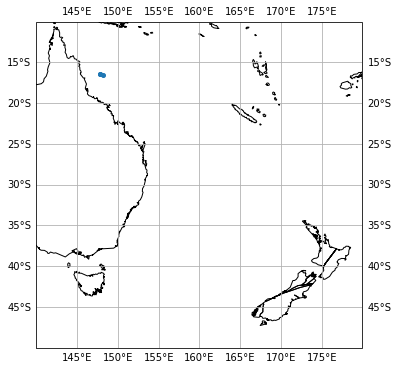

Quaternary (2.58, 0.0)


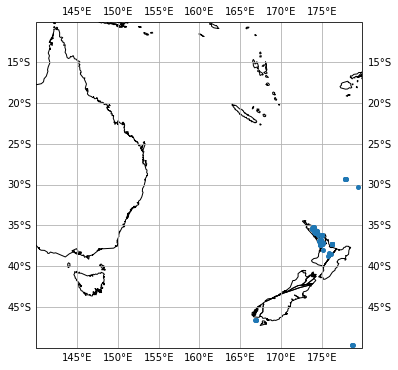

Triassic (251.90200000000002, 201.3)


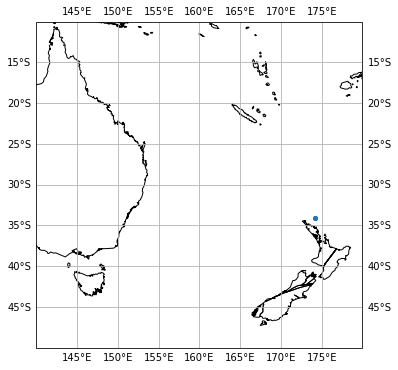

In [121]:
#Some insight into when deposits are layed down by geological age
groups=df.groupby(by=["Age_Max"])
print(groups.groups.keys())

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io import shapereader as shpreader

# import shapefile using cartopy io
shp = shpreader.Reader('coastline.shp')
shp_geom = shp.geometries()
ft_coastline = cfeature.ShapelyFeature(shp_geom, ccrs.PlateCarree(), facecolor='none', edgecolor='k')


#agekeys = [ts.text2age(name)[1] for name, group in groups]

##### groups = df.groupby(by=["Age_Max"])
for name, group in groups:
    print(name,ts.text2age(name))
    ts.text2age(name)
    
    fig = plt.figure(figsize=(6,6))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent([140,180, -50,-10], crs=ccrs.PlateCarree())
    
    ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
    ax.plot(group["Longitude"], group["Latitude"], marker="o", linestyle="", label=name)
    #plt.xlim(140,180)
    #plt.ylim(-50,-10)
    ax.add_feature(ft_coastline)
    plt.show()

## Set some functions for reading grids

In [42]:
def read_netcdf_grid(filename, return_grids=False, resample=None):
    """
    Read in a netCDF file and re-align from -180 to 180 degrees
    
    Parameters
    ----------
    filename : str
        path to netCDF file
    return_grids : bool
        optionally return lon, lat arrays associated with grid
    resample : tuple
        optionally resample grid, pass spacing in X and Y direction as a tuple
        e.g. resample=(spacingX, spacingY)
    """
    import netCDF4
    from scipy.interpolate import RegularGridInterpolator
    
    # open netCDF file and re-align from -180, 180 degrees
    with netCDF4.Dataset(filename, 'r') as cdf:
        cdf_grid = cdf["z"]
        try:
            cdf_lon = cdf['lon'][:]
            cdf_lat = cdf['lat'][:]
        except:
            cdf_lon = cdf['x'][:]
            cdf_lat = cdf['y'][:]
            
        cdf_lon_mask = cdf_lon[:] > 180
        
        if cdf_lon_mask.any():
            cdf_grid_z = np.hstack([cdf_grid[:,cdf_lon_mask], cdf_grid[:,~cdf_lon_mask]])
            cdf_lon = np.hstack([cdf_lon[cdf_lon_mask], cdf_lon[~cdf_lon_mask]])
        else:
            cdf_grid_z = cdf_grid[:]

    # resample
    if resample is not None:
        spacingX, spacingY = resample
        lon_grid = np.arange(cdf_lon.min(), cdf_lon.max()+spacingX, spacingX)
        lat_grid = np.arange(cdf_lat.min(), cdf_lat.max()+spacingY, spacingY)
        lonq, latq = np.meshgrid(lon_grid, lat_grid)
        interp = RegularGridInterpolator((cdf_lat, cdf_lon), cdf_grid_z, method='nearest', bounds_error=False)
        cdf_grid_z = interp((latq, lonq))
        cdf_lon = lon_grid
        cdf_lat = lat_grid
            
    if return_grids:
        return cdf_grid_z, cdf_lon, cdf_lat
    else:
        return cdf_grid_z
    
def fill_ndimage(data,invalid=None):
    """
    Replace the value of invalid 'data' cells (indicated by 'invalid')
    by the value of the nearest valid data cell
    """
    from scipy.ndimage import distance_transform_edt
    masked_array = hasattr(data, "fill_value")
    if masked_array:
        mask_fill_value = data.data == data.fill_value
        data = data.data.copy()
        data[mask_fill_value] = np.nan
    else:
        data = data.copy()

    if invalid is None:
        invalid = np.isnan(data)
        if masked_array:
            invalid += mask_fill_value
    ind = distance_transform_edt(invalid, return_distances=False, return_indices=True)
    return data[tuple(ind)]

def sample_grid(lon, lat, grid, extent):
    from scipy import interpolate
    
    rgi = interpolate.RegularGridInterpolator((np.linspace(extent[2], extent[3], grid.shape[0]),
                                               np.linspace(extent[0], extent[1], grid.shape[1])),
                                               grid)
    #Modified from original, only returning 1 value
    gridval=rgi(np.c_[lat, lon])
    
    return(gridval[0])

In [43]:
#Drop any points that don't have enough data we need
df = df[df['Latitude'].notna()]
df = df[df['Longitude'].notna()]
df = df[df['Age'].notna()]

In [44]:
#print(df.columns.values)

## Perform plate reconstructions on each point

In [45]:
#Get points, assign plate ids, rotate, return reconstucted point locations.
input_directory = "../Data/Muller_etal_2019_PlateMotionModel_v2.0_Tectonics/"
static_polygons_filename = input_directory+"StaticGeometries/StaticPolygons/Global_EarthByte_GPlates_PresentDay_StaticPlatePolygons_2019_v1.shp"
rotation_filenames = glob.glob(os.path.join(input_directory, '*.rot'))
rotation_model = pygplates.RotationModel(rotation_filenames)

In [46]:
#Assign PlateIDs to all the petlab points based on the present day static polygons they are in.
point_features=[]
for row in df.itertuples():
    #print(row.Latitude, row.Longitude,row.Age)
    point=pygplates.PointOnSphere(row.Latitude, row.Longitude)
    # Create an unclassified feature.
    # Set the feature's geometry to the input point.
    point_feature = pygplates.Feature()
    point_feature.set_geometry(point)
    point_feature.set_valid_time(np.ceil(row.Age),0)
    point_features.append(point_feature)   


In [47]:
# Use the static polygons to assign plate IDs and valid time periods.
# Each point feature is partitioned into one of the static polygons and assigned its
# reconstruction plate ID and valid time period.
assigned_point_features = pygplates.partition_into_plates(
    static_polygons_filename,
    rotation_model,
    point_features,
    properties_to_copy = [
        pygplates.PartitionProperty.reconstruction_plate_id,
        ])


In [48]:
rockgrid=[]
#Reconstruct each point based on ID and Age
for idx,i in enumerate(assigned_point_features):
    plateid = i.get_reconstruction_plate_id()
    recontime =i.get_valid_time()
    #print(plateid,recontime[0])
    point_to_rotate=i.get_geometry()
    #finite_rotation = rotation_model.get_rotation(to_time=recontime, moving_plate_id=plateid,from_time=0)
    stage_rotation = rotation_model.get_rotation(recontime[0], plateid, fixed_plate_id=0)
    birthPosition = stage_rotation * point_to_rotate
    point = birthPosition.to_lat_lon_array()
    rockgrid.append([point[0,1],point[0,0],recontime[0],plateid])   
    
rockgrid=np.array([np.array(xi) for xi in rockgrid])

In [49]:
#Put the results back in the dataframe
df['ReconLon'] = rockgrid[:,0]
df['ReconLat'] = rockgrid[:,1]
df['ReconAge'] = rockgrid[:,2]
df['ReconPlateID'] = rockgrid[:,3]

In [50]:
df

,Sample_ID,Collection,Coll_No,Plot_unit,Feature_Type,Feature_Name,Top_Depth,Bottom_Depth,Field_Number,Collection_Date,...,Pb206_204i_calc,Pb207_204i_calc,Pb208_204i_calc,Petlab notes,Age_Num,Age,ReconLon,ReconLat,ReconAge,ReconPlateID
0,32257,GNS P (P),40894,Whakaari,Surface,NaN,NaN,NaN,NaN,1981-01-01 00:00:00,...,NaN,NaN,NaN,NaN,2.58,0.0000,177.937800,-29.257800,0.0,839.0
1,125909,GNS P (P),79818,Arc,Surface,NaN,NaN,NaN,LS1,40220,...,NaN,NaN,NaN,NaN,2.58,0.0360,167.174994,-46.714965,1.0,81315.0
2,169088,other,RVAN-17-13.1,Arc,Dredge,Nesmeyanov-N17-13,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0400,179.033010,-31.237992,1.0,839.0
3,106981,other,BFH-MP112,Horomaka,Surface,NaN,NaN,NaN,NaN,33604,...,NaN,NaN,NaN,NaN,2.58,0.0530,176.269419,-37.569659,1.0,8065.0
4,107013,other,BFH-MP279,Horomaka,Surface,NaN,NaN,NaN,NaN,33604,...,NaN,NaN,NaN,NaN,2.58,0.0555,176.269419,-37.569659,1.0,8065.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
989,239784,GNS P (P),85736,Horomaka,Dredge,ECOSAT2-6,1500,1500,IN2016T01-DR6A,2016-07-06 00:00:00,...,NaN,NaN,NaN,NaN,145.00,5.0000,159.732763,-22.348980,5.0,869.0
990,212416,GNS P (P),82240,Horomaka,Dredge,SS2012v6-18,NaN,NaN,SS2012v6 DR18Bii,41230,...,NaN,NaN,NaN,NaN,298.90,58.0000,156.056486,-40.751994,58.0,869.0
991,60026,GNS P (P),44143,Horomaka,Surface,NaN,NaN,NaN,WI-1B,1983-11-01 00:00:00,...,NaN,NaN,NaN,NaN,145.00,60.0000,174.586122,-51.033195,60.0,8065.0
992,52516,GNS P (P),50288,Horomaka,Surface,NaN,NaN,NaN,320388,1988-03-17 00:00:00,...,NaN,NaN,NaN,NaN,145.00,60.0000,176.336076,-51.217357,60.0,8065.0


In [51]:
#Interrogate each grid to find the corresponding values for each of the samples

#Group the samples by age (i.e by grid file) for efficency
groups=df.groupby("ReconAge")
#print(groups.groups.keys())

In [52]:
#Set the file names of each of the grids
agegrid_filename = "../Data/M2020_AgeGrids/Muller_etal_2019_Tectonics_v2.0_AgeGrid-{:.0f}.nc"
carcrust_filename = "../Data/Crust/carbon_crust_grid_{:.0f}.nc"
subcarcrust_filename = "../Data/Crust/subducted_carbon_crust_{:.0f}.nc"
carlith_filename = "../Data/Lithosphere/carbon_lithosphere_grid_{:.0f}.nc"
subcarlith_filename = "../Data/Lithosphere/carbon_lithosphere_grid_{:.0f}.nc"
carsed_filename = "../Data/Sediment/carbon_sediment_grid_{:.0f}.nc"
subcarsed_filename ="../Data/Sediment/subducted_carbon_sediment_{:.0f}.nc"
carserp_filename = "../Data/Serpentinite/carbon_serpentinite_grid_{:.0f}.nc"
subcarserp_filename = "../Data/Serpentinite/subducted_carbon_serpentinite_{:.0f}.nc"
# slab_filename = "../Data/slab_tops.nc" #Think about how this gets coregistered to each point's birth position
#sed_filename = "../Data/decompacted_carbonate_sediment_thickness/decompacted_carbonate_sediment_thickness_mean/decompacted_sediment_thickness_0.5_{:.0f}.nc"

extent_globe = [-180, 180, -90, 90]

In [53]:
#Now co-register/sample the netcdf grids with the petlab points at their correpsonding birth ages

dfs=[]
for name, grp in groups:
    print(name)
    
    #Grids only exist up to 250Ma
    if (name < 251):
        age_grid = read_netcdf_grid(agegrid_filename.format(name))
        age_grid_filled = fill_ndimage(age_grid)

        crust_grid = read_netcdf_grid(carcrust_filename.format(name))
        crust_grid_filled = fill_ndimage(crust_grid)

        subcrust_grid = read_netcdf_grid(subcarcrust_filename.format(name))
        subcrust_grid_filled = fill_ndimage(subcrust_grid)

        lith_grid = read_netcdf_grid(carlith_filename.format(name))
        lith_grid_filled = fill_ndimage(lith_grid)

        sublith_grid = read_netcdf_grid(subcarlith_filename.format(name))
        sublith_grid_filled = fill_ndimage(sublith_grid)

        sed_grid = read_netcdf_grid(carsed_filename.format(name))
        sed_grid_filled = fill_ndimage(sed_grid)

        subsed_grid = read_netcdf_grid(subcarsed_filename.format(name))
        subsed_grid_filled = fill_ndimage(subsed_grid)

        serp_grid = read_netcdf_grid(carserp_filename.format(name))
        serp_grid_filled = fill_ndimage(serp_grid)

        subserp_grid = read_netcdf_grid(subcarserp_filename.format(name))
        subserp_grid_filled = fill_ndimage(subserp_grid)
        
#         slab_grid = read_netcdf_grid(slab_filename.format(name))
#         slab_grid_filled = fill_ndimage(slab_grid)
    
        #Apply the grid sampling for every point in each "age grouping"
        grp['gridage'] = grp.apply(lambda row: sample_grid(row['ReconLon'],row['ReconLat'],age_grid_filled,extent_globe),axis=1)
        grp['gridcrust'] = grp.apply(lambda row: sample_grid(row['ReconLon'],row['ReconLat'],crust_grid_filled,extent_globe),axis=1)
        grp['gridsubcrust'] = grp.apply(lambda row: sample_grid(row['ReconLon'],row['ReconLat'],subcrust_grid_filled,extent_globe),axis=1)
        grp['gridlith'] = grp.apply(lambda row: sample_grid(row['ReconLon'],row['ReconLat'],lith_grid_filled,extent_globe),axis=1)
        grp['gridsublith'] = grp.apply(lambda row: sample_grid(row['ReconLon'],row['ReconLat'],sublith_grid_filled,extent_globe),axis=1)
        grp['gridsed'] = grp.apply(lambda row: sample_grid(row['ReconLon'],row['ReconLat'],sed_grid_filled,extent_globe),axis=1)
        grp['gridsubsed'] = grp.apply(lambda row: sample_grid(row['ReconLon'],row['ReconLat'],subsed_grid_filled,extent_globe),axis=1)
        grp['gridserp'] = grp.apply(lambda row: sample_grid(row['ReconLon'],row['ReconLat'],serp_grid_filled,extent_globe),axis=1)
        grp['gridsubserp'] = grp.apply(lambda row: sample_grid(row['ReconLon'],row['ReconLat'],subserp_grid_filled,extent_globe),axis=1)
#         grp['gridslab'] = grp.apply(lambda row: sample_grid(row['ReconLon'],row['ReconLat'],slab_grid_filled,extent_globe),axis=1)

        
    else:
        grp['gridage'] = np.nan
        grp['gridcrust'] = np.nan
        grp['gridsubcrust'] = np.nan
        grp['gridlith'] = np.nan
        grp['gridsublith'] = np.nan
        grp['gridsed'] = np.nan
        grp['gridsubsed'] = np.nan
        grp['gridserp'] = np.nan
        grp['gridsubserp'] = np.nan
        
    
    #Add each group back to a list
    dfs.append(grp)
    
#Combine/merge all the groups back together
df1 = pd.concat(dfs, axis=0)

0.0
1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0
11.0
12.0
13.0
14.0
15.0
16.0
17.0
18.0
19.0
20.0
21.0
22.0
23.0
24.0
25.0
26.0
27.0
28.0
29.0
30.0
31.0
32.0
33.0
34.0
35.0
36.0
37.0
38.0
39.0
40.0
41.0
42.0
44.0
46.0
47.0
48.0
49.0
50.0
51.0
52.0
53.0
55.0
57.0
58.0
59.0
60.0
64.0
65.0
67.0
68.0
69.0
71.0
72.0
73.0
74.0
75.0
76.0
77.0
78.0
79.0
80.0
81.0
82.0
83.0
84.0
85.0
86.0
87.0
88.0
89.0
90.0
91.0
92.0
93.0
94.0
95.0
96.0
97.0
98.0
99.0
100.0
101.0
102.0
103.0
104.0
105.0
108.0
109.0
110.0
111.0
113.0
114.0
115.0
117.0
119.0
123.0
125.0
127.0
128.0
142.0
145.0
151.0
161.0
170.0
173.0
190.0
196.0
241.0
259.0
260.0
270.0
285.0
324.0
356.0
381.0


In [54]:
df1

,Sample_ID,Collection,Coll_No,Plot_unit,Feature_Type,Feature_Name,Top_Depth,Bottom_Depth,Field_Number,Collection_Date,...,ReconPlateID,gridage,gridcrust,gridsubcrust,gridlith,gridsublith,gridsed,gridsubsed,gridserp,gridsubserp
0,32257,GNS P (P),40894,Whakaari,Surface,NaN,NaN,NaN,NaN,1981-01-01 00:00:00,...,839.0,27.324570,0.000006,0.000000,0.000004,0.000004,0.000046,0.000000,0.0,0.000000
1,125909,GNS P (P),79818,Arc,Surface,NaN,NaN,NaN,LS1,40220,...,81315.0,105.385642,0.000009,0.000067,0.000004,0.000004,0.000006,0.000038,0.0,0.000593
2,169088,other,RVAN-17-13.1,Arc,Dredge,Nesmeyanov-N17-13,NaN,NaN,NaN,NaN,...,839.0,27.209710,0.000006,0.000020,0.000004,0.000004,0.000045,0.000006,0.0,0.000004
3,106981,other,BFH-MP112,Horomaka,Surface,NaN,NaN,NaN,NaN,33604,...,8065.0,93.313096,0.000008,0.000019,0.000004,0.000004,0.000121,0.000050,0.0,0.000002
4,107013,other,BFH-MP279,Horomaka,Surface,NaN,NaN,NaN,NaN,33604,...,8065.0,93.313096,0.000008,0.000019,0.000004,0.000004,0.000121,0.000050,0.0,0.000002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
976,109562,other,87-144A,Continent basement,Dredge,Sonne 36-57,2400,2700,unknown,1994-01-01 00:00:00,...,885.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
977,64286,GNS P (P),73035,Continent basement,Drillcore,ODP-824C,411.92,NaN,"133-824C-18R-1,42-45",32973,...,801.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
978,44824,GNS P (P),57235,Austral,Drillcore,Pakaha-1,3360,3363,Pakaha,28126,...,813.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
980,44823,GNS P (P),57234,Austral,Drillcore,Parara-1,3799,3802,Parara,27760,...,81315.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [55]:
df1.to_csv("reconpoints.csv",columns=["Latitude","Longitude","ReconAge","ReconPlateID"])

In [61]:
print(df1.columns.tolist())

['Sample_ID', 'Collection', 'Coll_No', 'Plot_unit', 'Feature_Type', 'Feature_Name', 'Top_Depth', 'Bottom_Depth', 'Field_Number', 'Collection_Date', 'Date_Rounding', 'Collectors', 'Country_Name', 'NZMG_Sheet', 'NZMG_East', 'NZMG_North', 'Latitude', 'Longitude', 'Method', 'Accuracy', 'Site_Description', 'In_Situ', 'Rock_Description', 'Colour', 'Litho2014_strat_name', 'Informal_strat_unit', 'Rock_Types', 'Age_Min', 'Age_Max', 'Sample_Types', 'Lab_Sample_ID(s)', 'Material(s)', 'Part_Analysed', 'Analysis_ID(s)', 'Investigator(s)', 'Analysis_Method(s)', 'Geochron_Method(s)', 'Laboratory(s)', 'Lab_Number(s)', 'Analysis_Date(s)', 'Analysis_Date_Rounding(s)', 'Analysis_Publication(s)', 'Analysis_Bib_Ref(s)', 'Analysis_Comment(s)', 'age_sample_result_Ma', 'age_sample_2sig_err_abs', 'SiO2', 'TiO2', 'Al2O3', 'FeOT', 'Fe2O3T', 'Fe2O3', 'FeO', 'MnO', 'MgO', 'CaO', 'Na2O', 'K2O', 'P2O5', 'Cr2O3', 'H2O_plus', 'H2O_minus', 'CO2', 'LOl', 'Majors_total', 'As', 'Ba', 'Ce', 'Co', 'Cr', 'Cs', 'Cu', 'Dy', 'E

In [73]:
#sigvars=["gridage","gridcrust","gridsubcrust","gridlith","gridsublith","gridsed","gridsubsed","gridserp","gridsubserp"]
#sigvars=df.columns.values
sigvars1=['SiO2', 'TiO2', 'Al2O3', 'FeOT', 'Fe2O3T', 'Fe2O3', 'FeO', 'MnO', 'MgO', 'CaO', 'Na2O']
sigvars2=['K2O', 'P2O5', 'Cr2O3', 'H2O_plus', 'H2O_minus', 'CO2', 'LOl', 'Majors_total', 'As', 'Ba', 'Ce'] 
sigvars3=['Co', 'Cr', 'Cs', 'Cu', 'Dy', 'Er', 'Eu', 'Ga', 'Gd', 'Hf', 'Ho', 'La', 'Lu', 'Nb', 'Nd', 'Ni', 'Pb'] 
sigvars4=['Pr', 'Rb', 'Sc', 'Sm', 'Sr', 'Ta', 'Tb', 'Th', 'Tm', 'U', 'V', 'Y', 'Yb', 'Zn', 'Zr', 'He4_raw_nnc']
sigvars5=['He4_corr_nnc', 'He_R_Ra_raw', 'He_R_Ra_corr', 'He_R_Ra_cor_err', 'dO18', 'Rb87_Sr86', 'Sr87_Sr86', 'Sr87_Sr86_err_abs']
sigvars6=['Sm147_Nd144', 'Nd143_Nd144', 'Nd143_Nd144_err_abs', 'Lu176_Hf177', 'Hf176_Hf177', 'Hf176_Hf177_err_abs', 'Pb206_Pb204']
sigvars7=['Pb206_Pb204_err_abs', 'Pb207_Pb204', 'Pb207_Pb204_err_abs', 'Pb208_Pb204', 'Pb208_Pb204_err_abs', 'age_model_assumed_Ma'] 
sigvars8=['Sr87_86i_calc', 'Nd143_144i_calc', 'eNdi_calc', 'Hf176_177i_calc', 'eHfi_calc', 'Pb206_204i_calc', 'Pb207_204i_calc', 'Pb208_204i_calc','ReconLon', 'ReconLat', 'ReconAge', 'ReconPlateID'] 
sigvars9=['gridage', 'gridcrust', 'gridsubcrust', 'gridlith', 'gridsublith', 'gridsed', 'gridsubsed', 'gridserp', 'gridsubserp']

In [151]:
sigvars=['SiO2', 'TiO2', 'Al2O3', 'FeOT', 'Fe2O3T', 'Fe2O3', 'FeO', 'MnO', 'MgO', 'CaO', 'Na2O', 'K2O', 'P2O5', 'Cr2O3', 'H2O_plus', 'H2O_minus', 'CO2', 'LOl', 'Majors_total', 'As', 'Ba', 'Ce', 'Co', 'Cr', 'Cs', 'Cu', 'Dy', 'Er', 'Eu', 'Ga', 'Gd', 'Hf', 'Ho', 'La', 'Lu', 'Nb', 'Nd', 'Ni', 'Pb', 'Pr', 'Rb', 'Sc', 'Sm', 'Sr', 'Ta', 'Tb', 'Th', 'Tm', 'U', 'V', 'Y', 'Yb', 'Zn', 'Zr', 'He4_raw_nnc', 'He4_corr_nnc', 'He_R_Ra_raw', 'He_R_Ra_corr', 'He_R_Ra_cor_err', 'dO18', 'Rb87_Sr86', 'Sr87_Sr86', 'Sr87_Sr86_err_abs', 'Sm147_Nd144', 'Nd143_Nd144', 'Nd143_Nd144_err_abs', 'Lu176_Hf177', 'Hf176_Hf177', 'Hf176_Hf177_err_abs', 'Pb206_Pb204', 'Pb206_Pb204_err_abs', 'Pb207_Pb204', 'Pb207_Pb204_err_abs', 'Pb208_Pb204', 'Pb208_Pb204_err_abs', 'Sr87_86i_calc', 'Nd143_144i_calc', 'eNdi_calc', 'Hf176_177i_calc', 'eHfi_calc', 'Pb206_204i_calc', 'Pb207_204i_calc', 'Pb208_204i_calc', 'Age_Num', 'Age', 'ReconLon', 'ReconLat', 'ReconAge', 'ReconPlateID', 'gridage', 'gridcrust', 'gridsubcrust', 'gridlith', 'gridsublith', 'gridsed', 'gridsubsed', 'gridserp', 'gridsubserp']

<AxesSubplot:>

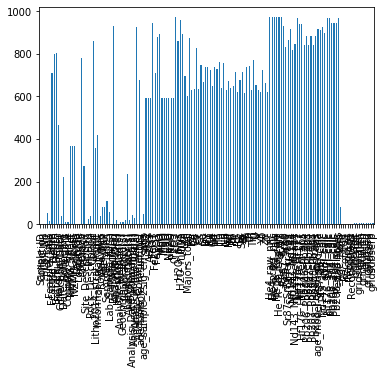

In [295]:
#How many NaNs per feature?

vc_nulls = df1.apply(lambda x: x.isnull().value_counts()).T[True]
#vc_nulls.hist() # if you want a histogram of these counts
## or if you wanted to plot the null count of each column as a bar
vc_nulls.plot(kind = 'bar')

In [ ]:
#df1.to_csv("df1.csv",columns=sigvars)

In [177]:
#limitPer = len(df1) * .05
#df2 = df1[sigvars].dropna(thresh=limitPer,axis=1)

In [204]:
#Just keep the rows that have CO3
df2=df1[df1['CO2'].notna()]
df2.dropna(axis=1,inplace=True)

In [206]:
df2.columns

Index(['Sample_ID', 'Collection', 'Coll_No', 'Feature_Type', 'Collection_Date',
       'Collectors', 'Country_Name', 'Latitude', 'Longitude', 'In_Situ',
       'Rock_Description', 'Rock_Types', 'Age_Min', 'Age_Max', 'Sample_Types',
       'Lab_Sample_ID(s)', 'Material(s)', 'Analysis_ID(s)', 'Investigator(s)',
       'Analysis_Method(s)', 'Laboratory(s)', 'Analysis_Date(s)',
       'Analysis_Date_Rounding(s)', 'Analysis_Publication(s)',
       'age_sample_result_Ma', 'age_sample_2sig_err_abs', 'SiO2', 'TiO2',
       'Al2O3', 'MnO', 'MgO', 'CaO', 'Na2O', 'K2O', 'P2O5', 'H2O_plus', 'CO2',
       'Majors_total', 'Age_Num', 'Age', 'ReconLon', 'ReconLat', 'ReconAge',
       'ReconPlateID', 'gridage', 'gridcrust', 'gridsubcrust', 'gridlith',
       'gridsublith', 'gridsed', 'gridsubsed', 'gridserp', 'gridsubserp'],
      dtype='object')

In [218]:
df2['Rock_Types']

48                         basaltic
49                         basaltic
70                         basaltic
104            basaltic & basanitic
105            basaltic & basanitic
                   ...             
912    hypabyssal: basic & gabbroic
924                        basaltic
940                        gabbroic
945    basaltic & hypabyssal: basic
955                        basaltic
Name: Rock_Types, Length: 81, dtype: object

In [219]:
sigvars=['SiO2', 'TiO2',
       'Al2O3', 'MnO', 'MgO', 'CaO', 'Na2O', 'K2O', 'P2O5', 'H2O_plus', 'CO2',
       'Majors_total', 'Age_Num', 'Age', 'ReconLon', 'ReconLat', 'ReconAge',
       'ReconPlateID', 'gridage', 'gridcrust', 'gridsubcrust', 'gridlith',
       'gridsublith', 'gridsed', 'gridsubsed', 'gridserp', 'gridsubserp']

catvars=['Rock_Types','Age_Min','Age_Max']

In [58]:
import seaborn as sns

In [70]:
df1.replace(["<0.01","<0.05","<0.3","<0.4","<0.5","<0.6","<0.7","<1","<1.0","<10.0","<2.0","<3.0","<5.0","<50.0"],[0.01,0.05,0.3,0.4,0.5,0.6,0.7,1,1.0,10.0,2.0,3.0,5.0,50.0],inplace=True)
df1.replace(["bd"],[0.0],inplace=True)

In [77]:
dfsub=df1[sigvars]

In [86]:
np.shape(dfsub)

(972, 100)

In [90]:
#sns.pairplot(dfsub,hue="ReconAge")
dfsub.columns[91:100].tolist()+ ['ReconAge'] + ['CO2'] 

['gridage',
 'gridcrust',
 'gridsubcrust',
 'gridlith',
 'gridsublith',
 'gridsed',
 'gridsubsed',
 'gridserp',
 'gridsubserp',
 'ReconAge',
 'CO2']

<Figure size 432x288 with 0 Axes>

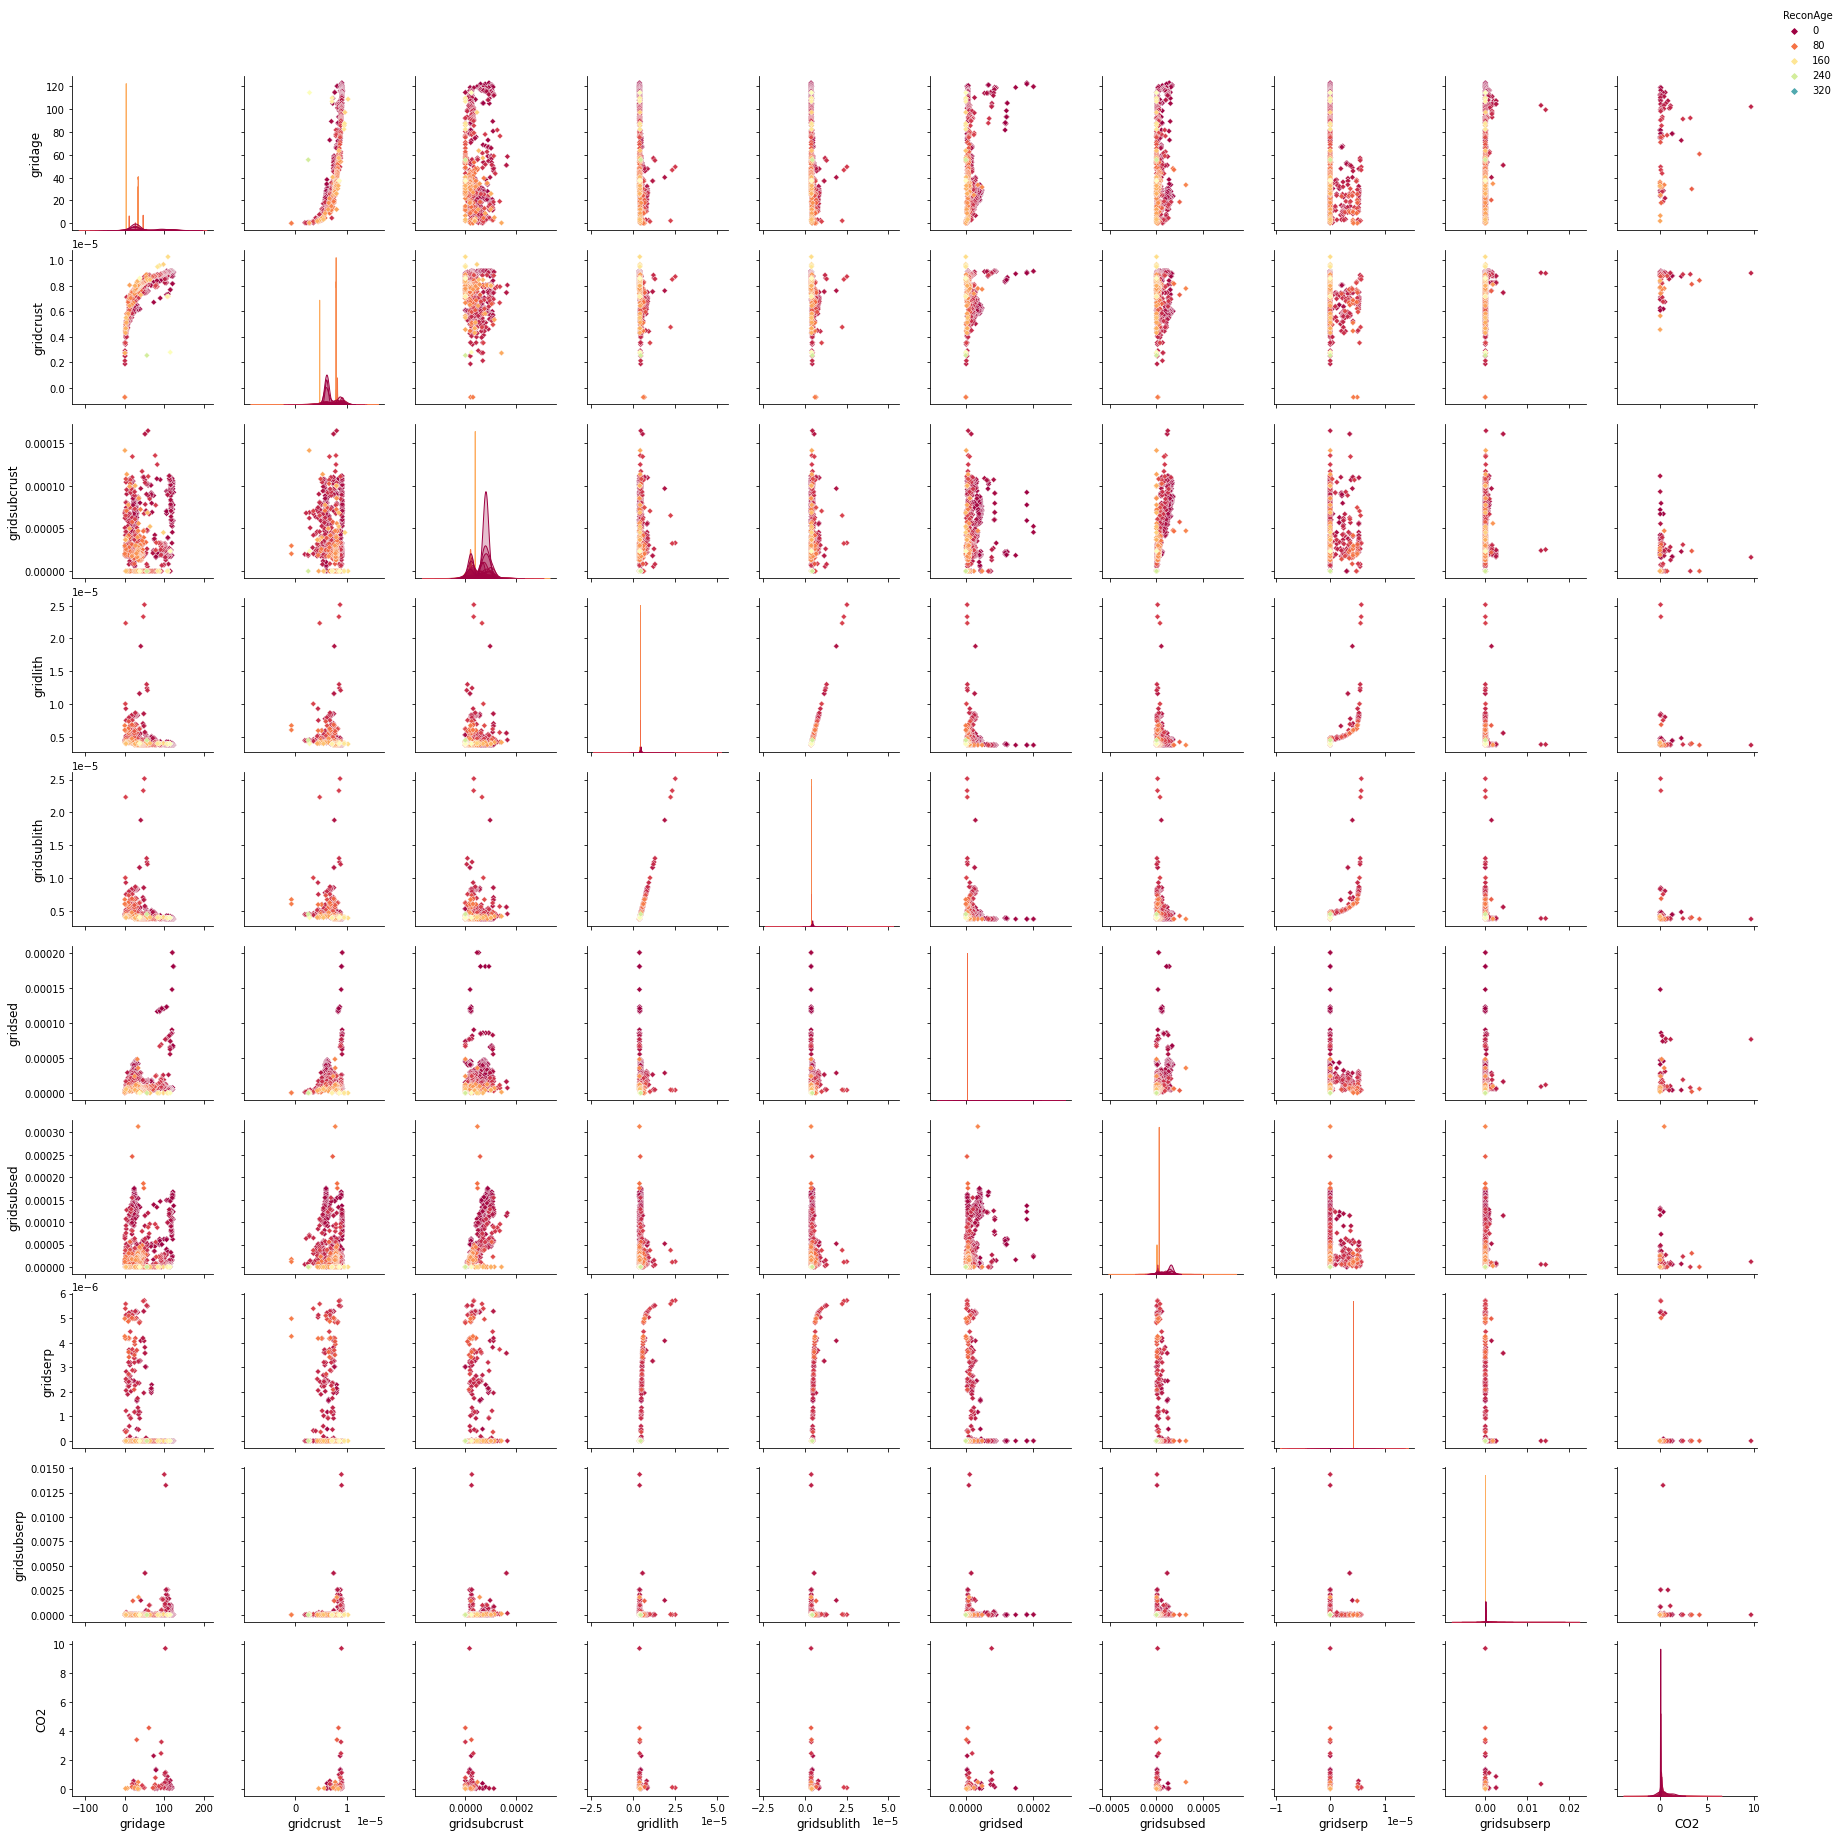

<Figure size 432x288 with 0 Axes>

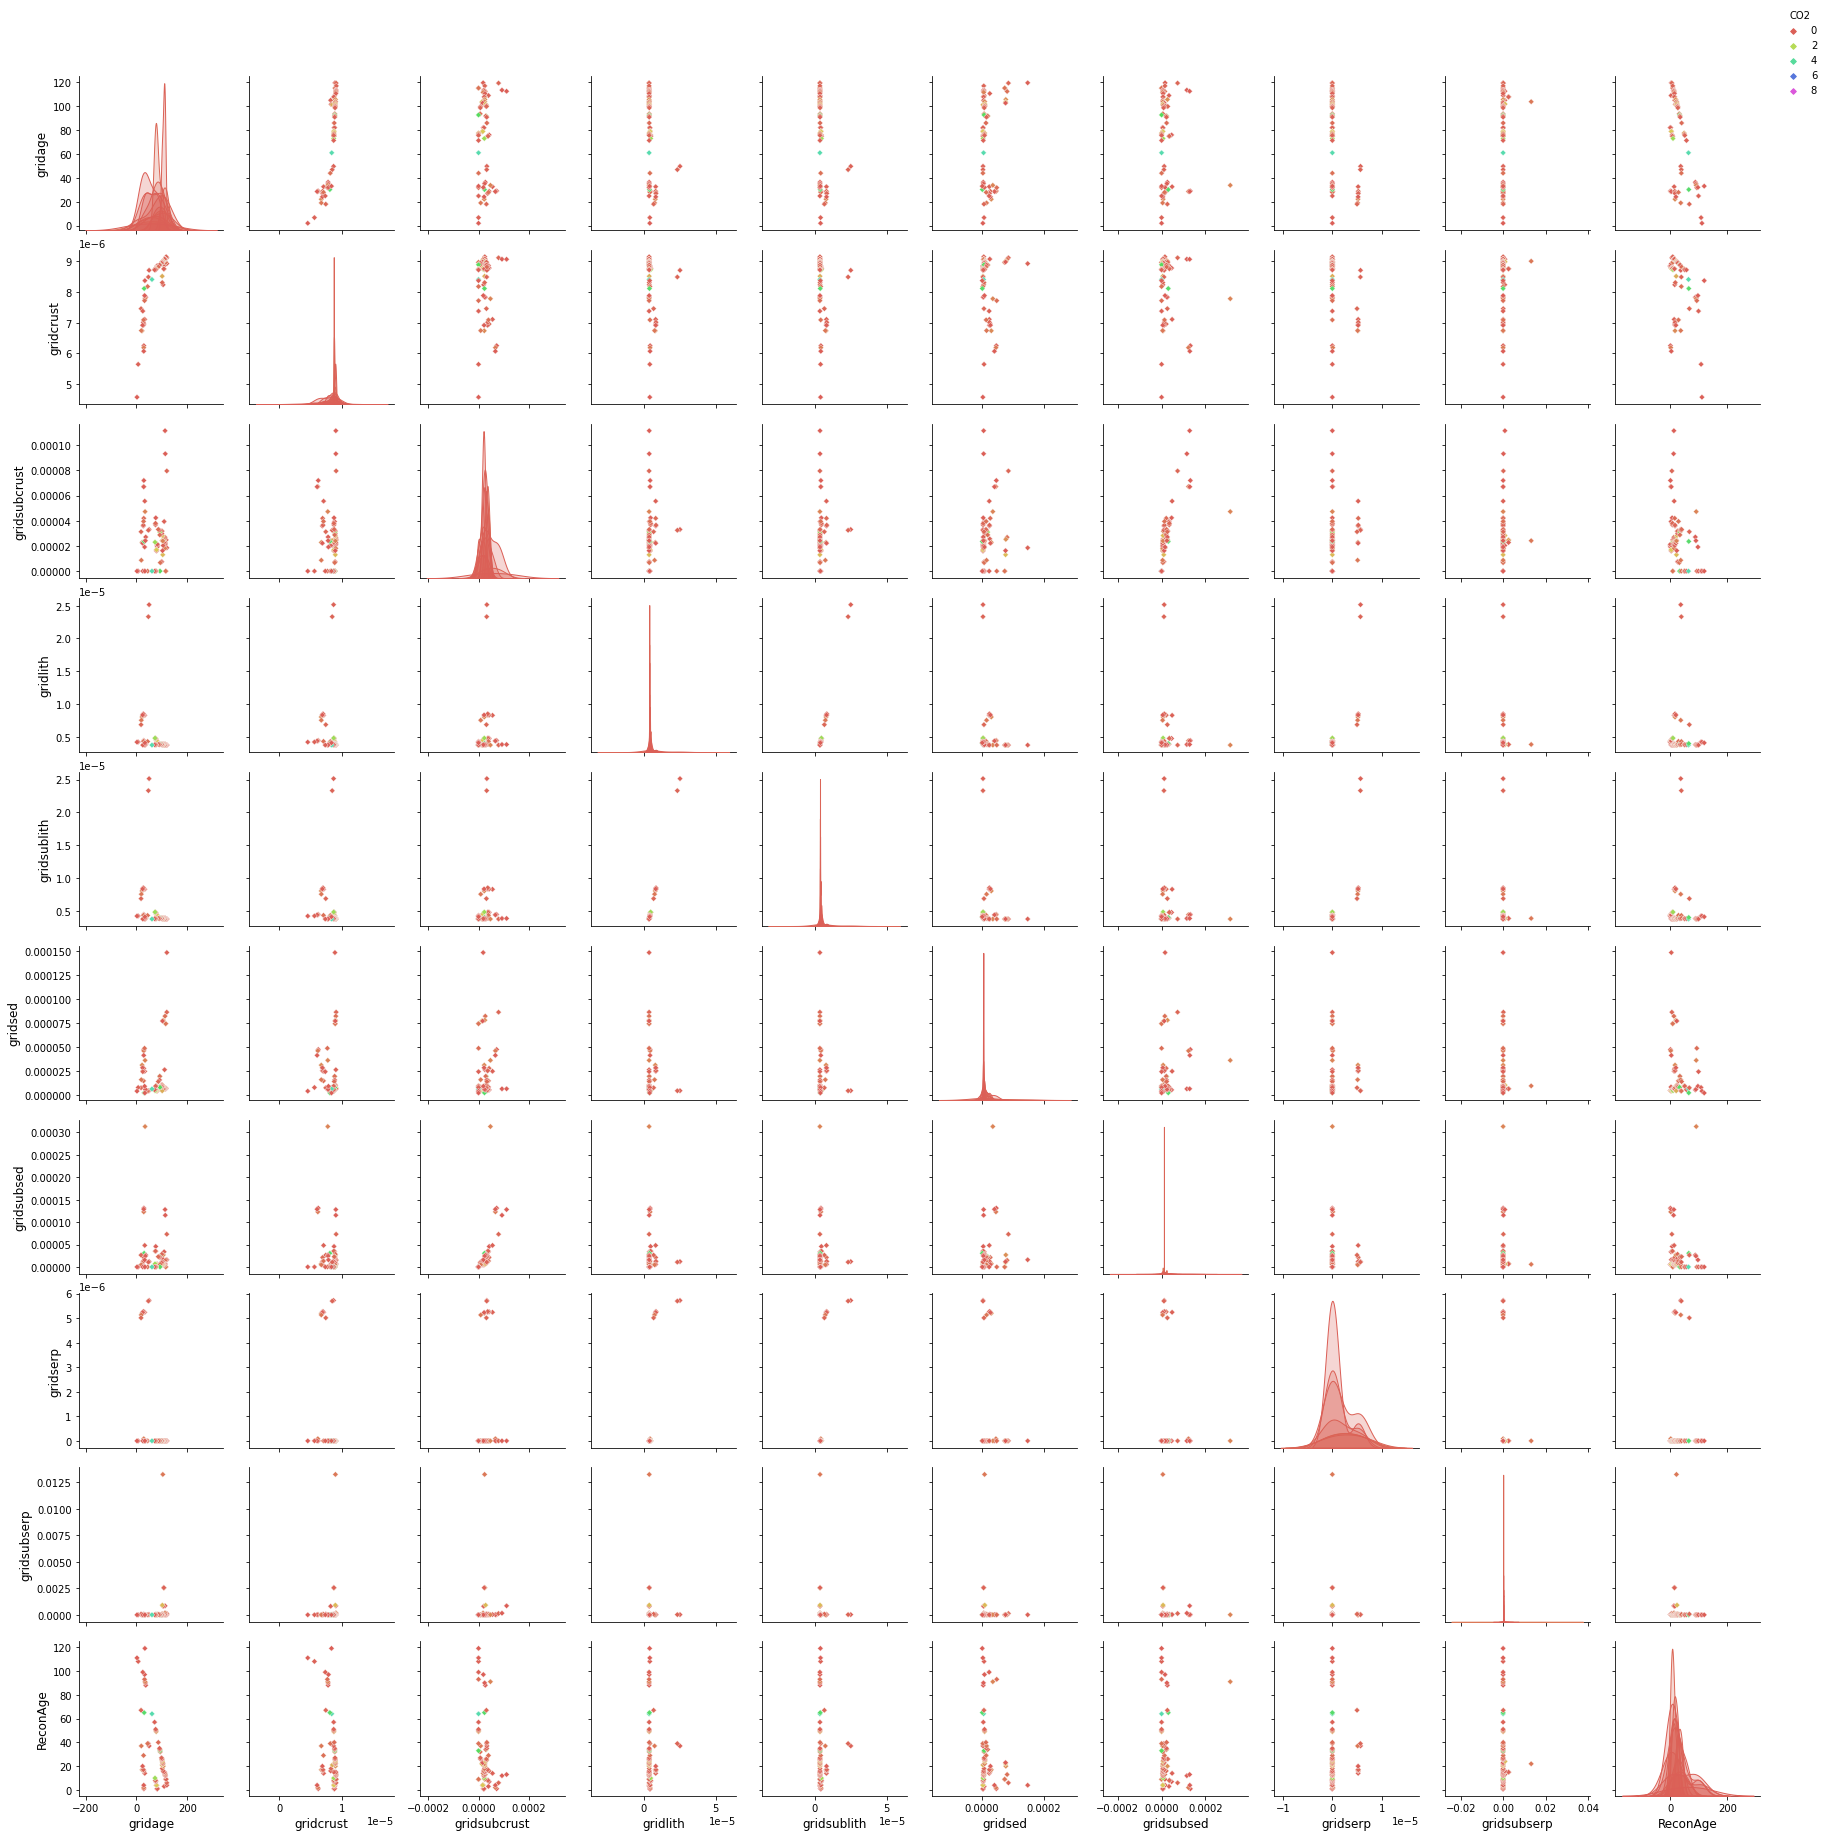

In [91]:
# Plot all the columns, break it up because there are too many
# plt.figure()
# cols_to_plot = dfsub.columns[0:10].tolist() + ['ReconAge'] 
# sns.pairplot(dfsub[cols_to_plot], hue ="ReconAge",palette="hls")
# plt.show()

# plt.figure()
# cols_to_plot = dfsub.columns[10:20].tolist() + ['ReconAge'] 
# sns.pairplot(dfsub[cols_to_plot], hue ="ReconAge",palette="hls")
# plt.show()

# plt.figure()
# cols_to_plot = dfsub.columns[20:30].tolist() + ['ReconAge'] 
# sns.pairplot(dfsub[cols_to_plot], hue ="ReconAge",palette="hls")
# plt.show()

plt.figure()
cols_to_plot = dfsub.columns[91:100].tolist() + ['ReconAge'] + ['CO2'] 
sns.pairplot(dfsub[cols_to_plot], hue ="ReconAge",palette="Spectral")
plt.show()

plt.figure()
cols_to_plot = dfsub.columns[91:100].tolist() + ['ReconAge'] + ['CO2'] 
sns.pairplot(dfsub[cols_to_plot], hue ="CO2",palette="hls")
plt.show()


In [140]:
g.axes[0,1].set_xlim((0,2))

(0.0, 2.0)

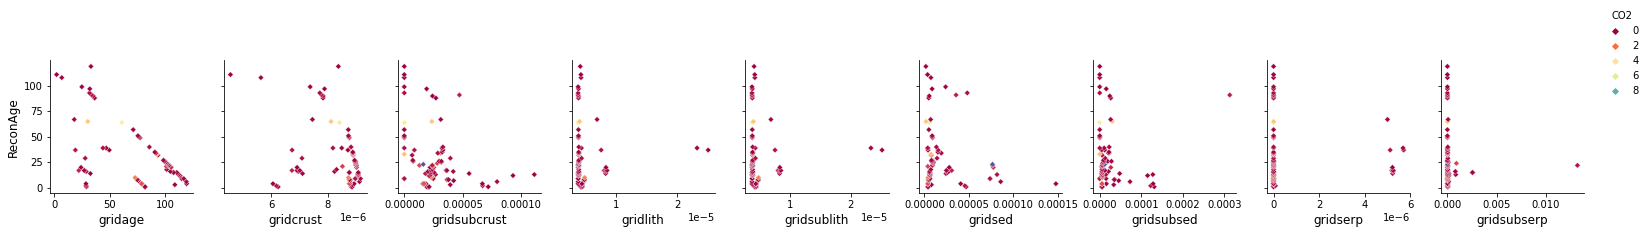

In [141]:
#CO2, ReconAge


# sns.pairplot(df1, y_vars="ReconAge", x_vars=sigvars1)
# sns.pairplot(df1, y_vars="ReconAge", x_vars=sigvars2)
# sns.pairplot(df1, y_vars="ReconAge", x_vars=sigvars3)
# sns.pairplot(df1, y_vars="ReconAge", x_vars=sigvars4)
# sns.pairplot(df1, y_vars="ReconAge", x_vars=sigvars5)
# sns.pairplot(df1, y_vars="ReconAge", x_vars=sigvars6)
# sns.pairplot(df1, y_vars="ReconAge", x_vars=sigvars7)
# sns.pairplot(df1, y_vars="ReconAge", x_vars=sigvars8)

sns.pairplot(df1, y_vars="ReconAge", x_vars=sigvars9,hue ="CO2",palette="Spectral")


#plt.plot(df1["CO2"],df1["gridcrust"],'k.')


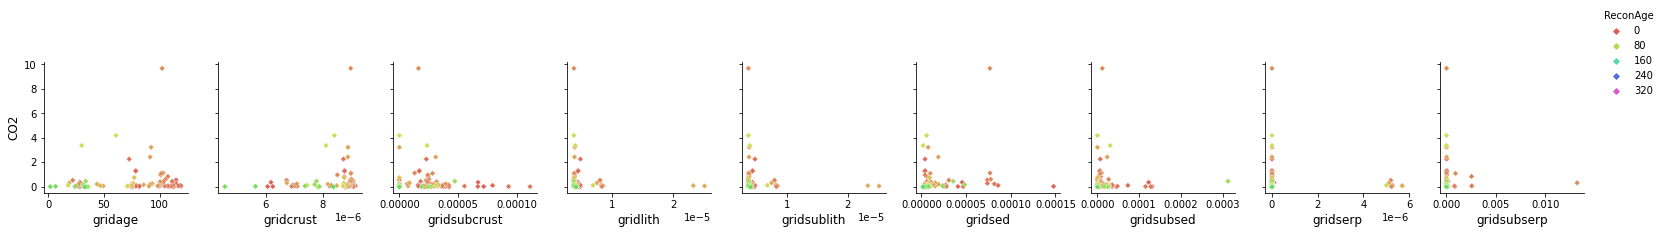

In [143]:
# sns.pairplot(df1, y_vars="CO2", x_vars=sigvars1)
# sns.pairplot(df1, y_vars="CO2", x_vars=sigvars2)
# sns.pairplot(df1, y_vars="CO2", x_vars=sigvars3)
# sns.pairplot(df1, y_vars="CO2", x_vars=sigvars4)
# sns.pairplot(df1, y_vars="CO2", x_vars=sigvars5)
# sns.pairplot(df1, y_vars="CO2", x_vars=sigvars6)
# sns.pairplot(df1, y_vars="CO2", x_vars=sigvars7)
# sns.pairplot(df1, y_vars="CO2", x_vars=sigvars8)
sns.pairplot(df1, y_vars="CO2", x_vars=sigvars9,hue ="ReconAge",palette="hls")

In [145]:
from sklearn.model_selection import cross_val_score
#from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [225]:
#Create the 'feature vector' and a 'target classification vector'
features=df2[sigvars+catvars]
targets=df2.CO2

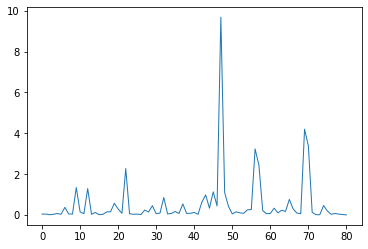

In [236]:
plt.plot(df2.CO2.values)

In [289]:
targets=pd.qcut(df2.CO2,5,labels=False)
targets

48     0
49     0
70     0
104    0
105    1
      ..
912    0
924    1
940    0
945    0
955    0
Name: CO2, Length: 81, dtype: int64

In [290]:
#Create the ML classifier with numerical and categorical data
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
   ('imputer', SimpleImputer(strategy='constant')),
   ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, sigvars),
        ('cat', categorical_transformer, catvars)])

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
rf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', RandomForestClassifier())])


Random Forest...
Done RF
RF 10-fold cross validation Scores: [0.444 0.625 0.5   0.75  0.5   0.625 0.25  0.375 0.625 0.375]
SCORE Mean: 0.51 STD: 0.14 



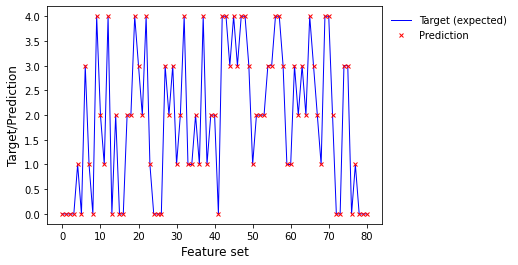

In [291]:
#Train the random forest
print('Random Forest...')

rf.fit(features,targets)
print("Done RF")

scores = cross_val_score(rf, features,targets, cv=10)
print("RF 10-fold cross validation Scores:", scores)
print("SCORE Mean: %.2f" % np.mean(scores), "STD: %.2f" % np.std(scores), "\n")

plt.plot(targets.values,'b-',label='Target (expected)')
plt.plot(rf.predict(features),'rx',label='Prediction')
plt.xlabel("Feature set")
plt.ylabel("Target/Prediction")
plt.legend()

In [292]:
ft_imp=[]
ft_lab=[]
np.set_printoptions(precision=3,suppress=True)
for i,lab in enumerate(np.append(sigvars,rf['preprocessor'].transformers_[1][1]['onehot'].get_feature_names(catvars))):
    #if rf.steps[1][1].feature_importances_[i] > 1*np.mean(rf.steps[1][1].feature_importances_): 
    #print(i, rf.steps[1][1].feature_importances_[i],lab )
    print("%1.3f \t %s" % (rf.steps[1][1].feature_importances_[i],lab))
    ft_imp.append(rf.steps[1][1].feature_importances_[i])
    ft_lab.append(lab)

0.041 	 SiO2
0.029 	 TiO2
0.038 	 Al2O3
0.028 	 MnO
0.030 	 MgO
0.039 	 CaO
0.037 	 Na2O
0.026 	 K2O
0.032 	 P2O5
0.039 	 H2O_plus
0.216 	 CO2
0.034 	 Majors_total
0.009 	 Age_Num
0.040 	 Age
0.024 	 ReconLon
0.025 	 ReconLat
0.029 	 ReconAge
0.011 	 ReconPlateID
0.024 	 gridage
0.025 	 gridcrust
0.027 	 gridsubcrust
0.023 	 gridlith
0.025 	 gridsublith
0.037 	 gridsed
0.032 	 gridsubsed
0.007 	 gridserp
0.030 	 gridsubserp
0.004 	 Rock_Types_basaltic
0.001 	 Rock_Types_basaltic & arenaceous (sst) & rudaceous (cgl, br)
0.001 	 Rock_Types_basaltic & basanitic
0.002 	 Rock_Types_basaltic & hypabyssal: basic
0.000 	 Rock_Types_basaltic & pyroclastic rock
0.001 	 Rock_Types_basaltic & rudaceous (cgl, br)
0.001 	 Rock_Types_basanitic
0.001 	 Rock_Types_basanitic & hypabyssal: basic
0.002 	 Rock_Types_basanitic & lava flow
0.000 	 Rock_Types_gabbroic
0.000 	 Rock_Types_hypabyssal: acid & syenitic
0.001 	 Rock_Types_hypabyssal: basic & gabbroic
0.000 	 Rock_Types_peralkaline & trachytic
0.001

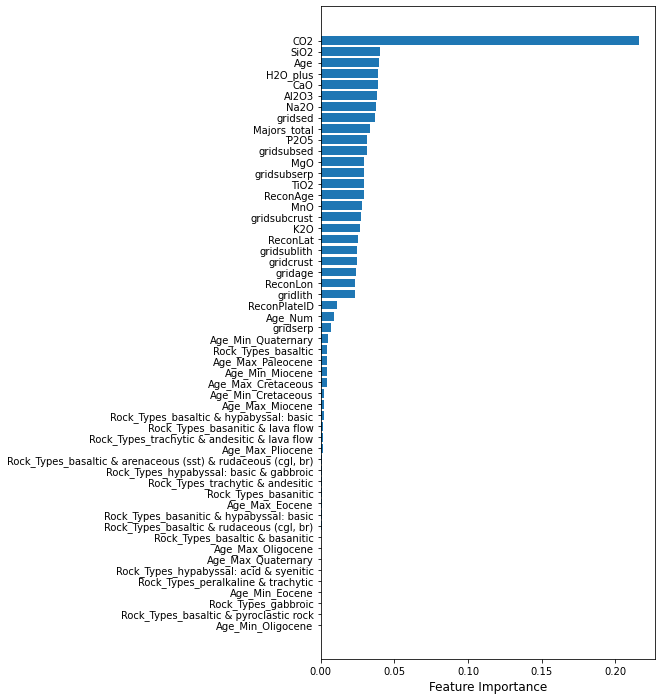

In [293]:
ft_imps, ft_labs = (list(t) for t in zip(*sorted(zip(ft_imp,ft_lab))))

datalength=len(ft_imp)

#Create a new figur
#fig = plt.figure(figsize=(10,10),dpi=150)
fig,ax = plt.subplots(figsize=(6,12))

#Plot the bar graph
rects=ax.barh(np.arange(0, datalength, step=1),ft_imps)

#Label the axes
ax.set_yticks(np.arange(0, datalength, step=1))
ax.set_yticklabels(ft_labs)

ax.set_xlabel('Feature Importance')

#Print the feature importance to compare with plot
np.set_printoptions(precision=3,suppress=True)
# print("Importance \t Feature")
# for i,label in enumerate(ft_lab):
#     print("%1.3f \t\t %s" % (ft_imp[i],ft_lab[i]))

plt.show()